<a href="https://colab.research.google.com/github/Liam-E2/NovSevenTweets/blob/master/Final_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import random
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
import nltk
from matplotlib import style
from sklearn.gaussian_process import *
style.use('default')

## LiveLessful Twitter Analytics

In [0]:
# Step 1: Load in data and merge into one dataset

# Twitter only exports up to one month at a time, so we need to record data over time
url1 = "https://raw.githubusercontent.com/Liam-E2/NovSevenTweets/master/tweet_activity_metrics_livelessful_20191021_20191113_en.csv"
url2 = "https://raw.githubusercontent.com/Liam-E2/NovSevenTweets/master/tweet_activity_metrics_livelessful_20191030_20191121_en.csv"

checkpoint = pd.read_csv(url1)
final = pd.read_csv(url2)

In [0]:
# Combine datasets and remove redundant observations
def combine_tweets(df1, df2):
  # List of final tweets
  final_tweets = df2['Tweet text'].unique()

  # Identify redundant tweets in checkpoint dataset and drop
  def apply_func(row):
    return 0 if row['Tweet text'] in final_tweets else 1
  
  df1['IsInFinal'] = df1.apply(lambda row: apply_func(row), axis=1)
  df1 = df1[df1.IsInFinal == 1]

  # Merge data and drop a few non-useful columns
  df_final = pd.concat([df1, df2], axis=0, sort=False).drop(['IsInFinal', 'Tweet id', 'Tweet permalink','app opens', 'app installs', 'hashtag clicks'], axis=1).reset_index()

  # Since we didn't promote, drop promoted columns
  promoted = [str(col) for col in df_final.keys() if 'promoted' in col]
  df_final.drop(columns=promoted, inplace=True)

  # Multiply Engagement Rate
  df_final['engagement rate'] = df_final['engagement rate']*100

  return df_final

In [0]:
from google.colab import files
df = combine_tweets(checkpoint, final)
df.head()
csv = df.to_csv("AllTweets.csv")
files.download("AllTweets.csv")

In [0]:
def parse_time(df):
  # Time manipulation
  df.time = pd.to_datetime(df.time)
  df.time = df.time.dt.tz_convert('EST') #convert from UTC to EST (UTC -5)
  df['hour'] = df.time.apply(lambda x: x.hour)
  df['weekday'] = df.time.apply(lambda x: x.weekday)
  df['dayofcampaign'] = df.time.apply(lambda x: x.date - datetime.date(2019, 10, 21))
  df['dayofcampaign'] = df.dayofcampaign.apply(lambda x: x.days)
  return df.sort_values(by='time', axis=0).reset_index()



In [0]:
# Parse time and remove post-deadline tweets
df = parse_time(df)
df = df.iloc[0:76] # Hacky but I didn't want to deal with tz converting

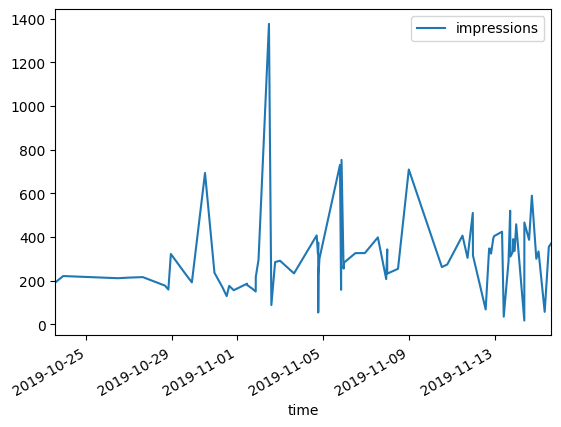

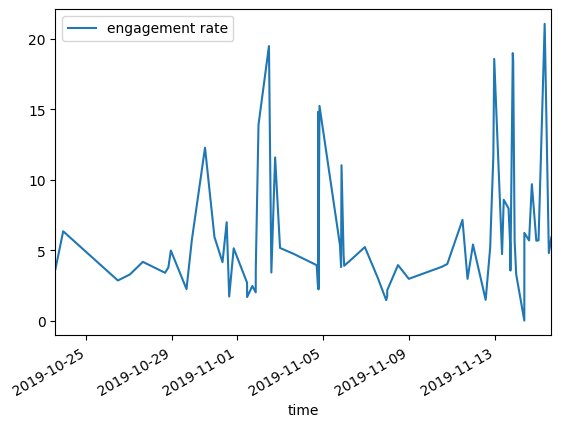

In [7]:
# Time series plots of key metrics
df.plot(x='time', y='impressions')
df.plot(x='time', y='engagement rate')

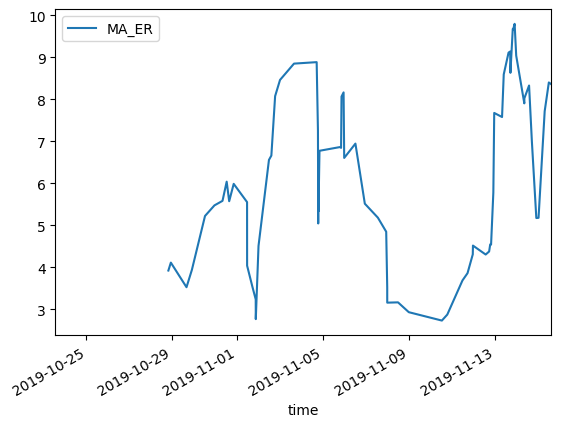

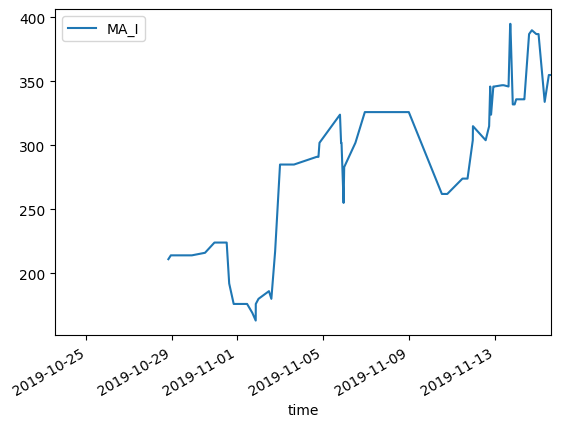

In [8]:
df['MA_ER'] = df['engagement rate'].rolling(window=7).mean()
df['MA_I'] = df['impressions'].rolling(window=7).median()
df.plot(x='time', y='MA_ER')
df.plot(x='time', y='MA_I')

Text(0, 0.5, 'Count')

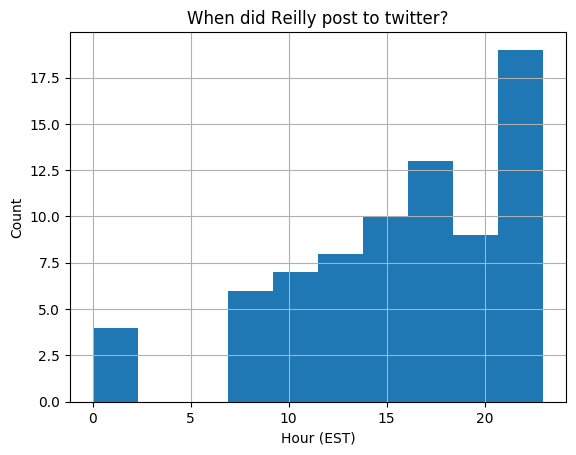

In [9]:
df.hour.hist()
plt.title("When did Reilly post to twitter?")
plt.xlabel("Hour (EST)")
plt.ylabel("Count")

In [0]:
# Partition Data
y = df['engagement rate']
x = pd.concat([df.hour, df.weekday], axis=1)

# note: TTSPLIT parameter only for predictive tinkering purposes; leave at 1. It's not functioning as a predictive model.
TTSPLIT = 1
traincases = random.sample(range(len(y)), round(TTSPLIT*len(y)))

xtr = x.iloc[x.index.isin(traincases)]
ytr = y.iloc[y.index.isin(traincases)]
xtest = x.iloc[~x.index.isin(traincases)]
ytest = y.iloc[~y.index.isin(traincases)]

In [0]:
kernel2 = kernels.Matern() # Generalized Radial Basis Function
model2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=20, alpha=0.1, normalize_y=False)

model2.fit(xtr.values.reshape(len(xtr), -1), ytr.values.reshape(-1,1))
params2 = model2.get_params()

0.7040130318026451

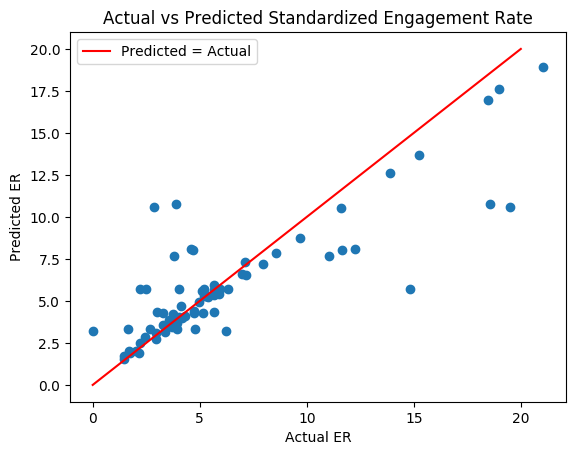

In [12]:
# Now that we have high-dimensional data, it's more difficult to visualize...

actual = ytr.values.reshape(-1, 1)
predicted, stds = model2.predict(xtr.values.reshape(len(xtr), -1), return_std=True)

plt.title("Actual vs Predicted Standardized Engagement Rate")
plt.scatter(actual, predicted)
plt.plot((0, 20), (0, 20), label='Predicted = Actual', c='red')
plt.legend()
plt.xlabel("Actual ER")
plt.ylabel("Predicted ER")

model2.score(xtr.values.reshape(len(xtr), -1), ytr.values.reshape(-1, 1))

In [0]:
# Append predicted values to dataframe
preds = pd.Series(predicted.flatten())
df['predicted_ER'] = preds

In [0]:
# Seperate data into over/underperformers
Above = df[df['engagement rate'] > df.predicted_ER]
Below = df[df['engagement rate'] < df.predicted_ER]

In [15]:
def process_splits(df):
  df['err'] = df['engagement rate'] - df.predicted_ER
  tdf = pd.concat([df['Tweet text'], df['engagement rate'], df['err']], axis=1).sort_values(by='err')
  return tdf[np.abs(tdf.err) > 2]

Above = process_splits(Above)
Below = process_splits(Below)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
pd.set_option('display.max_colwidth', -1)
Above['Tweet text']

73    @valeriazamare @SadhanaShakti1 Yeah hahah it was supposed to be humorous because it actually is extremely difficult. here’s another version. I hope you both have an amazing day full of love and peace 💛 https://t.co/kscUwscslm
68    if you wake up on the wrong side of the bed, go back to sleep and wake up on the other side. simple as that                                                                                                                      
35    watch The Real Bros of Simi Valley (on YouTube) https://t.co/VVH2CXV5sA                                                                                                                                                          
56    release all of the sounds trapped in your ~mind~ https://t.co/erm0zvLDIA                                                                                                                                                         
10    13; tell your homies you love them                                

In [17]:
Below['Tweet text']

2     number 5; don’t drink coffee before bed, straight up                           
37    wear your retainer                                                             
34    eat fruit                                                                      
31    only eat cereal at night                                                       
38    every once in a while, send yourself a package to pretend like you have friends
36    kiss ~and I cannot stress this enough~ your homies goodnight                   
28    don’t give into to peer pressure. unless u a lil b*tch.                        
67    @sassyarcherboy Lmaooo yeah honestly probably a good idea                      
Name: Tweet text, dtype: object

In [0]:
def generate_day_plot(metric, days=range(7)):

  # Isolate Weekdays, by default the whole week
  daydf = df[df.weekday.isin(days)]
  daydf = daydf[daydf.impressions < 1000] # Hacky removal of the "Snoop Outlier, a quasi-viral tweet featuring Snoop Dogg"

  # Isolate metric and 
  ytr = daydf[metric]
  xtr = daydf.hour

  # Define Gaussian Process Model for performance across Hours
  kernel = kernels.Matern()*kernels.ConstantKernel() # Generalized Radial Basis Function * a constant term
  model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=0.1, normalize_y=False)

  # Fit Model 
  model.fit(xtr.values.reshape(-1, 1), ytr.values.reshape(-1,1))
  params = model.get_params()

  # Domain for Plot Predictions
  X = np.linspace(0, 24, 60)
  X = np.atleast_2d(X).T

  # Generate Predictions across X of the mean and 95% CI for the mean
  mu_s, std_s = model.predict(X, return_std=True)
  upper = np.add(mu_s.flatten(), std_s*1.96)
  lower = np.add(mu_s.flatten(), std_s*-1.96)

  # Plot the Model
  plt.title("Fitting a Gaussian Process to Twitter Data")
  plt.ylabel(f'{metric}')
  plt.xlabel('Hour Posted')
  plt.scatter(xtr, ytr, label='Actual', color='red')
  plt.fill_between(X.flatten(), y1=upper.flatten(), y2=lower.flatten(), color='teal', alpha=0.5)
  plt.plot(X, mu_s, label='Predicted')

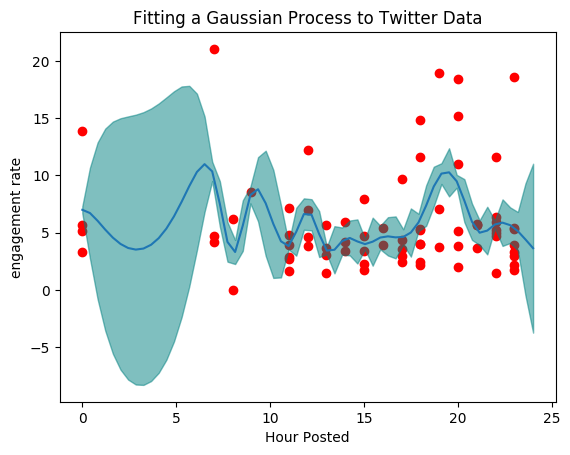

In [31]:
generate_day_plot('engagement rate')